In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
class FuzzyCMeans:
    
    def __init__(self, X, n_clusters, n_iter=100, limit=1e-3, p=2):
        self.X = X
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.limit = limit
        self.p = p
        self.error = 0
        self.distance_matrix = None
        self.centroids = np.zeros((self.n_clusters, len(self.X[0])))
        self.membership_matrix = self.init_membership_matrix()

            
    def init_membership_matrix(self):
        temp = np.zeros((1, self.n_clusters))
        for i in range(len(self.X)):
            temp = np.append(temp, np.reshape(np.random.dirichlet(np.ones(self.n_clusters), size=1), (1, self.n_clusters)), axis=0)
        return temp[1:]
    
    def update_centroids(self):
        for k in range(self.n_clusters):
            for i in range(len(self.X[0])):
                num, den = (0, 0)
                for j in range(len(self.X)):
                    num = num + (self.X[j][i] * pow(self.membership_matrix[j][k], self.p))
                    den = den + (pow(self.membership_matrix[j][k], self.p))
                self.centroids[k][i] = num / den
                
    def update_distance_matrix(self):
        if self.distance_matrix is None:
            self.distance_matrix = np.zeros((len(self.X), self.n_clusters))
            
        for i in range(len(self.X)):
            for j in range(self.n_clusters):
                self.distance_matrix[i][j] = np.linalg.norm(self.X[i] - self.centroids[j])
    
    def update_membership_matrix(self):
        for i in range(len(self.X)):
            for j in range(self.n_clusters):
                u1, u2 = (pow(1 / self.distance_matrix[i][j], 1 / (self.p - 1)), 0)
                for k in range(self.n_clusters):
                    u2 = u2 + pow(1 / self.distance_matrix[i][k], 1 / (self.p-1))
                self.membership_matrix[i][j] = u1 / u2
                
    def calculate_error(self):
        error = 0
        for i in range(len(self.X)):
            for j in range(self.n_clusters):
                error = error + (pow(self.membership_matrix[i][j], self.p) * pow(self.distance_matrix[i][j], 2))
        self.error = error
        
    def train(self):
        for i in range(self.n_iter):
            old_centroids = np.copy(self.centroids)
            old_error = self.error
            self.update_centroids()
            self.update_distance_matrix()
            self.update_membership_matrix()
            self.calculate_error()
            
            if (abs(old_error - self.error) < self.limit) or \
                (np.sum(np.abs(old_centroids - self.centroids)) < 0.0001):
                break
                
    @classmethod
    def plot_elbow_curve(cls, X, start, end, step):
        errors = []
        n_cluster = []
        for i in range(start, end + 1, step):
            n_cluster.append(i)
            temp_obj = FuzzyCMeans(X, i)
            temp_obj.train()
            errors.append(temp_obj.error)
        
        plt.plot(n_cluster, errors, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Error')
        plt.title("Fuzzy - CMeans")

In [3]:
data = pd.read_pickle('./state_clubbed_df.pickle')
data

,state,year,murder,rape,foeticide,kidnapping and abduction,abetment of suicide,exposure and abandonment,procuration of minor girls,selling girls for prostitution,prohibition of child marriage act,other crimes,total
0,andhra pradesh,2001,35.0,84.0,0.0,57.0,7.0,22.0,12.0,0.0,6.0,47.0,270.0
1,arunachal pradesh,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,assam,2001,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
3,bihar,2001,2.0,16.0,0.0,26.0,0.0,1.0,16.0,1.0,2.0,18.0,83.0
4,chhattisgarh,2001,14.0,150.0,5.0,46.0,1.0,15.0,0.0,0.0,0.0,354.0,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,d&n haveli,2015,2.0,2.0,0.0,14.0,0.0,2.0,0.0,0.0,0.0,2.0,35.0
523,daman & diu,2015,1.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
524,delhi,2015,54.0,927.0,3.0,6881.0,0.0,23.0,0.0,6.0,0.0,231.0,9489.0
525,lakshadweep,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [4]:
all_headers = data.columns
all_headers

Index(['state', 'year', 'murder', 'rape', 'foeticide',
       'kidnapping and abduction', 'abetment of suicide',
       'exposure and abandonment', 'procuration of minor girls',
       'selling girls for prostitution', 'prohibition of child marriage act',
       'other crimes', 'total'],
      dtype='object')

In [5]:
cols_to_norm = all_headers[2:-1]
print (cols_to_norm)

Index(['murder', 'rape', 'foeticide', 'kidnapping and abduction',
       'abetment of suicide', 'exposure and abandonment',
       'procuration of minor girls', 'selling girls for prostitution',
       'prohibition of child marriage act', 'other crimes'],
      dtype='object')


In [6]:
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])
data

,state,year,murder,rape,foeticide,kidnapping and abduction,abetment of suicide,exposure and abandonment,procuration of minor girls,selling girls for prostitution,prohibition of child marriage act,other crimes,total
0,andhra pradesh,2001,-0.088951,-0.293383,-0.422895,-0.331227,0.899853,-0.024876,-0.085015,-0.183679,0.287960,-0.288916,270.0
1,arunachal pradesh,2001,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,0.0
2,assam,2001,-0.518114,-0.556170,-0.422895,-0.372629,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,18.0
3,bihar,2001,-0.493590,-0.506115,-0.422895,-0.364137,-0.281905,-0.417052,-0.041155,-0.092531,-0.198824,-0.349356,83.0
4,chhattisgarh,2001,-0.346449,-0.086907,0.247176,-0.342905,-0.113082,-0.155602,-0.216594,-0.183679,-0.442216,0.350914,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,d&n haveli,2015,-0.493590,-0.549913,-0.422895,-0.376876,-0.281905,-0.398377,-0.216594,-0.183679,-0.442216,-0.382702,35.0
523,daman & diu,2015,-0.505852,-0.556170,-0.422895,-0.369445,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,28.0
524,delhi,2015,0.144024,2.343874,-0.020852,6.913125,-0.281905,-0.006201,-0.216594,0.363206,-0.442216,0.094565,9489.0
525,lakshadweep,2015,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.384786,2.0


In [7]:
import nbimporter
from pca import PCA

Importing Jupyter notebook from pca.ipynb


In [8]:
n_features = len(cols_to_norm)
n_features

10

Plotting the variance ratio curve to choose the optimal number of principal components from the dataset

([<matplotlib.axis.XTick at 0x7f32fb4c6790>,
 <a list of 10 Text major ticklabel objects>)

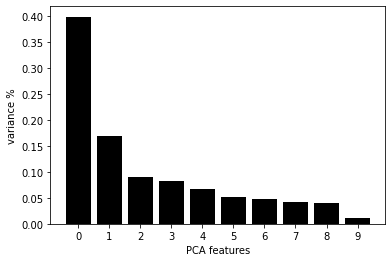

In [9]:
pca = PCA(n_components=n_features)
principal_components = pca.fit_transform(data[cols_to_norm].to_numpy())
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [10]:
PCA_components = pd.DataFrame(principal_components)
PCA_components = pd.concat([data[all_headers[:2]], PCA_components.loc[:, [0,1]]], axis=1)
PCA_components

,state,year,0,1
0,andhra pradesh,2001,-0.228578,0.050406
1,arunachal pradesh,2001,-1.230578,-0.237921
2,assam,2001,-1.224106,-0.236560
3,bihar,2001,-1.098062,0.019818
4,chhattisgarh,2001,-0.259834,-0.514825
...,...,...,...,...
522,d&n haveli,2015,-1.199630,-0.241129
523,daman & diu,2015,-1.218726,-0.236485
524,delhi,2015,3.331256,0.160154
525,lakshadweep,2015,-1.229735,-0.238179


<module 'matplotlib.pyplot' from '/home/pranjal/.local/share/virtualenvs/crime-analysis-report-pk3Cf-oK/lib/python3.7/site-packages/matplotlib/pyplot.py'>

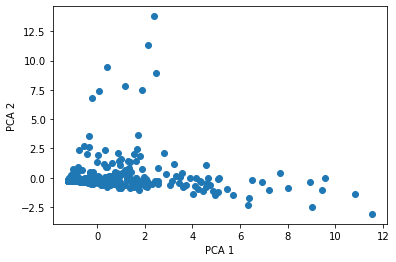

In [11]:
plt.scatter(PCA_components[0], PCA_components[1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt

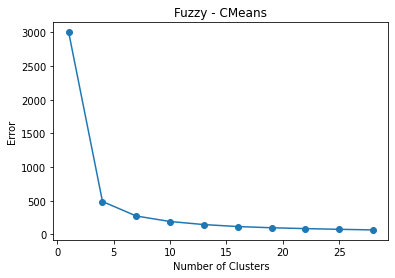

In [12]:
FuzzyCMeans.plot_elbow_curve(PCA_components.loc[:, [0,1]].to_numpy(), 1, 30, 3)

In [13]:
clusterer = FuzzyCMeans(PCA_components.loc[:, [0,1]].to_numpy(), n_clusters=5)
clusterer.train()

In [14]:
clusterer.centroids

array([[ 0.49579698,  0.12197893],
       [ 1.26816691,  0.4340353 ],
       [-1.07853253, -0.2023906 ],
       [ 4.39558133, -0.22638544],
       [ 1.70591474,  0.32330593]])

Text(0.5, 1.0, 'FuzzyCMeans')

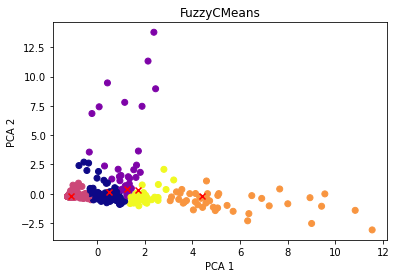

In [15]:
labels = np.argmax(clusterer.membership_matrix, axis=1)
plt.scatter(PCA_components[0], PCA_components[1], c=labels, cmap='plasma')
plt.scatter(clusterer.centroids[:, 0],clusterer.centroids[:, 1], color='red', marker='x')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.title('FuzzyCMeans')

In [16]:
labelled_data = pd.concat([data, pd.Series(labels)], axis=1).rename(columns={0: "label"})
labelled_data

,state,year,murder,rape,foeticide,kidnapping and abduction,abetment of suicide,exposure and abandonment,procuration of minor girls,selling girls for prostitution,prohibition of child marriage act,other crimes,total,label
0,andhra pradesh,2001,-0.088951,-0.293383,-0.422895,-0.331227,0.899853,-0.024876,-0.085015,-0.183679,0.287960,-0.288916,270.0,0
1,arunachal pradesh,2001,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,0.0,2
2,assam,2001,-0.518114,-0.556170,-0.422895,-0.372629,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,18.0,2
3,bihar,2001,-0.493590,-0.506115,-0.422895,-0.364137,-0.281905,-0.417052,-0.041155,-0.092531,-0.198824,-0.349356,83.0,2
4,chhattisgarh,2001,-0.346449,-0.086907,0.247176,-0.342905,-0.113082,-0.155602,-0.216594,-0.183679,-0.442216,0.350914,585.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,d&n haveli,2015,-0.493590,-0.549913,-0.422895,-0.376876,-0.281905,-0.398377,-0.216594,-0.183679,-0.442216,-0.382702,35.0,2
523,daman & diu,2015,-0.505852,-0.556170,-0.422895,-0.369445,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,28.0,2
524,delhi,2015,0.144024,2.343874,-0.020852,6.913125,-0.281905,-0.006201,-0.216594,0.363206,-0.442216,0.094565,9489.0,3
525,lakshadweep,2015,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.384786,2.0,2


Here we are printing the states which belong to same cluster (year wise)

In [17]:
unique_states = []
year =  2013
for i in range(5):
    unique_states.append(labelled_data.loc[(labelled_data['year'] == year) & (labelled_data['label'] == i)]['state'].to_numpy())
print (year)
unique_states

2013


[array(['bihar', 'odisha', 'punjab'], dtype=object),
 array(['gujarat', 'karnataka', 'tamil nadu', 'west bengal'], dtype=object),
 array(['arunachal pradesh', 'assam', 'goa', 'himachal pradesh',
        'jammu & kashmir', 'jharkhand', 'manipur', 'meghalaya', 'mizoram',
        'nagaland', 'sikkim', 'tripura', 'uttarakhand', 'a&n islands',
        'chandigarh', 'd&n haveli', 'daman & diu', 'lakshadweep',
        'puducherry'], dtype=object),
 array(['chhattisgarh', 'madhya pradesh', 'maharashtra', 'rajasthan',
        'uttar pradesh', 'delhi'], dtype=object),
 array(['andhra pradesh', 'haryana', 'kerala'], dtype=object)]